In [2]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
MHz, kHz, us, ns = 2 * jnp.pi, 2 * jnp.pi / 1e3, 1, 1e-3

# SignX

In [4]:
def get_signX(N0: int):
    """Returns the signX operator."""
    a = dq.destroy(N0)
    D, P = jnp.linalg.eigh(dq.dag(a) + a)
    return P @ jnp.diag(jnp.sign(D)) @ dq.dag(P)

# One trajectory

In [5]:
Na = 50

evol_under_two_ph = False

delta_a = 1 * MHz
kappa_a = 100 * kHz
n_th = 0.9
kappa_phi = 100 * kHz
kappa_2 = 0.350 * MHz

alpha_0 = 2

dt = 10 * ns
t_deflate = 1 * us
t_evol = 20 * us
t_inflate = 1 * us

In [6]:
a = dq.destroy(Na)

H_deflate = 0 * dq.eye(Na)
c_ops_deflate = [jnp.sqrt(kappa_2) * a @ a, jnp.sqrt(kappa_a) * a]

H_evol = delta_a * dq.dag(a) @ a
c_ops_evol = [jnp.sqrt(kappa_a) * a]
if evol_under_two_ph:
    c_ops_evol.append(jnp.sqrt(kappa_2) * a @ a)

H_inflate = 0 * dq.eye(Na)
c_ops_inflate = [
    jnp.sqrt(kappa_2) * (a @ a - alpha_0**2 * dq.eye(Na)),
    jnp.sqrt(kappa_a * (1 + n_th)) * a,
    jnp.sqrt(kappa_a * n_th) * dq.dag(a),
]

sgn_X = get_signX(Na)

In [7]:
rho_0 = dq.coherent(Na, alpha_0)
output_deflate = dq.mesolve(
    H_deflate, c_ops_deflate, rho_0, tsave=jnp.arange(0, t_deflate + dt / 2, dt)
)
states = output_deflate.states
tsaves = output_deflate.tsave
output_evol = dq.mesolve(
    H_evol, c_ops_evol, states[-1], tsave=jnp.arange(0, t_evol + dt / 2, dt)
)
states = jnp.concatenate((states, output_evol.states))
tsaves = jnp.concatenate((tsaves, output_evol.tsave))
output_inflate = dq.mesolve(
    H_inflate, c_ops_inflate, states[-1], tsave=jnp.arange(0, t_inflate + dt / 2, dt)
)
states = jnp.concatenate((states, output_inflate.states))
tsaves = jnp.concatenate((tsaves, output_inflate.tsave))

|██████████| 100.0% ◆ elapsed 881.80ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 757.52ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 957.50ms ◆ remaining 0.00ms  


100%|██████████| 50/50 [00:04<00:00, 12.21it/s]


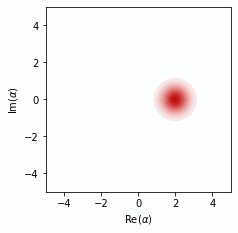

In [9]:
dq.plot.wigner_gif(states)

# Full trajectory

In [10]:
def exp_decay(time, A, T2, detuning):
    return A * jnp.exp(-time / T2) * jnp.cos(detuning * time)

In [22]:
Na = 20

evol_under_two_ph = True

delta_a = 0.1 * MHz

kappa_a = 10 * kHz
n_th = 0.93
kappa_phi = 10 * kHz
kappa_2 = 0.350 * MHz

alpha_0 = 2

t_deflate = 1 * us
t_evol = jnp.linspace(0, 1, 1001) * 40 * us

In [23]:
a = dq.destroy(Na)

H_deflate = 0 * dq.eye(Na)
c_ops_deflate = [
    # jnp.sqrt(kappa_2) * a @ a,
    jnp.sqrt(kappa_a * (1 + n_th)) * a,
    jnp.sqrt(kappa_a * n_th) * dq.dag(a),
    jnp.sqrt(kappa_phi * 2) * dq.dag(a) @ a,
]

H_evol = delta_a * dq.dag(a) @ a
c_ops_evol = [jnp.sqrt(kappa_a) * a, jnp.sqrt(kappa_phi * 2) * dq.dag(a) @ a]
if evol_under_two_ph:
    c_ops_evol.append(jnp.sqrt(kappa_2) * a @ a)

sgn_X = get_signX(Na)

In [24]:
rho_0 = dq.coherent(Na, alpha_0)
output_deflate = dq.mesolve(H_deflate, c_ops_deflate, rho_0, tsave=[0, t_deflate])
output_evol = dq.mesolve(
    H_evol, c_ops_evol, output_deflate.states[-1], tsave=t_evol, exp_ops=[sgn_X]
)

|██████████| 100.0% ◆ elapsed 5.20ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 3.69s ◆ remaining 0.00ms  


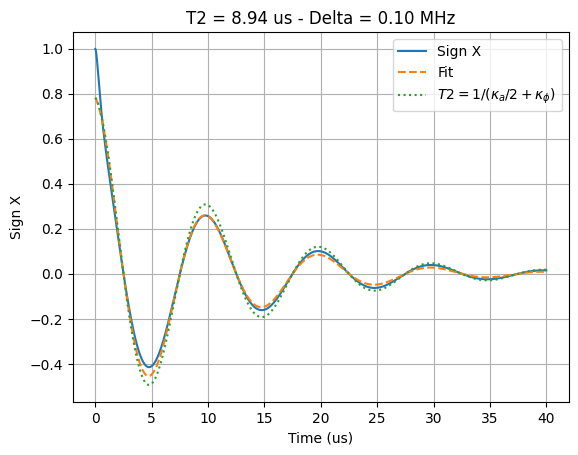

In [25]:
simu_data = output_evol.expects[0].real
plt.plot(t_evol, simu_data, label="Sign X")
popt, pcov = curve_fit(
    exp_decay, t_evol, simu_data, p0=[0.5, 1 / (kappa_a + kappa_phi), delta_a]
)
plt.plot(t_evol, exp_decay(t_evol, *popt), "--", label="Fit")
plt.plot(
    t_evol,
    exp_decay(t_evol, *(popt[0], 1 / (kappa_a / 2 + kappa_phi), delta_a)),
    ":",
    label="$T2 = 1/(\\kappa_a/2 + \\kappa_\\phi)$",
)
plt.title(f"T2 = {popt[1]/us:.2f} us - Delta = {popt[2]/MHz:.2f} MHz")
plt.legend()
plt.grid()
plt.xlabel("Time (us)")
plt.ylabel("Sign X")
plt.show()

In [43]:
dq.expect(sgn_X, states[-1])

Array(0.00129849+0.j, dtype=complex64)

In [189]:
1 / (9.3 * kHz / 2 + 16 * kHz) / us

7.707261166677739

In [197]:
1 / ((1 / 70 / us) / 2 + 10.5 * kHz) / us

13.676840332066874

In [198]:
1 / (16 * kHz) / us

9.947183943243457